In [2]:
# Running on GPU?
import setGPU

import getpass
import h5py
import pickle
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm

from tqdm import tnrange, tqdm_notebook

setGPU: Setting GPU to: 3


In [3]:
import os
import getpass
# Get permission to access EOS (Insert your NICE password)
os.system("echo %s | kinit" % getpass.getpass())

········


0

In [4]:
import json
import numpy as np
import pandas as pd
from pprint import pprint

import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, Lambda, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.activations import sigmoid, linear, relu
from keras.models import Model, load_model
from keras.regularizers import l1, l2, l1_l2

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

from scipy.stats import pearsonr

Using TensorFlow backend.


In [5]:
plt.rcParams.update({'font.size': 22})

In [9]:
PDs  = {1: 'BTagCSV',
        2: 'BTagMu',
        3: 'Charmonium',
        4: 'DisplacedJet',
        5: 'DoubleEG',
        6: 'DoubleMuon',
        7: 'DoubleMuonLowMass',
        8: 'FSQJets',
        9: 'HighMultiplicityEOF',
        10: 'HTMHT',
        11: 'JetHT',
        12: 'MET',
        13: 'MinimumBias',
        14: 'MuonEG',
        15: 'MuOnia',
        16: 'NoBPTX',
        17: 'SingleElectron',
        18: 'SingleMuon',
        19: 'SinglePhoton',
        20: 'Tau',
        21: 'ZeroBias'}

# Select PD
nPD = 6 # DoubleMuon

In [7]:
legend = [{"name": 'pf_jets', "start": 0, "end": 776},
          {"name": 'cal_jet_mets', "start": 777, "end": 944},
          {"name": 'pho', "start": 945, "end": 1280},
          {"name": 'muons', "start": 1281, "end": 1784},
          {"name": 'pf_jets2', "start": 1785, "end": 1889},
          {"name": 'pf_mets', "start": 1890, "end": 1917},
          {"name": 'nvtx', "start": 1918, "end": 1924},
          {"name": 'cal_jet_mets2', "start": 1925},
          {"name": 'sc', "start": 2037, "end": 2127},
          {"name": 'cc', "start": 2128, "end": 2169},
          {"name": 'pho2', "start": 2170, "end": 2365},
          {"name": 'muons2', "start": 2366, "end": 2491},
          {"name": 'ebs', "start": 2492, "end": 2701},
          {"name": 'hbhef', "start": 2702, "end": 2764},
          {"name": 'presh', "start": 2765, "end": 2806},
          {"name": 'inst_lumi', "start": 2807, "end": 2808}]

In [8]:
# Feature description
feature_names = ['qPFJetPt', 'qPFJetEta', 'qPFJetPhi', 'qPFJet0Pt', 'qPFJet1Pt', 'qPFJet2Pt', 'qPFJet3Pt', 'qPFJet4Pt', 'qPFJet5Pt', 'qPFJet0Eta', 'qPFJet1Eta', 'qPFJet2Eta', 'qPFJet3Eta', 'qPFJet4Eta', 'qPFJet5Eta', 'qPFJet0Phi', 'qPFJet1Phi', 'qPFJet2Phi', 'qPFJet3Phi', 'qPFJet4Phi', 'qPFJet5Phi', 'qPFJet4CHS0Pt', 'qPFJet4CHS1Pt', 'qPFJet4CHS2Pt', 'qPFJet4CHS3Pt', 'qPFJet4CHS4Pt', 'qPFJet4CHS5Pt', 'qPFJet4CHS0Eta', 'qPFJet4CHS1Eta', 'qPFJet4CHS2Eta', 'qPFJet4CHS3Eta', 'qPFJet4CHS4Eta', 'qPFJet4CHS5Eta', 'qPFJet4CHS0Phi', 'qPFJet4CHS1Phi', 'qPFJet4CHS2Phi', 'qPFJet4CHS3Phi', 'qPFJet4CHS4Phi', 'qPFJet4CHS5Phi', 'qPFJet8CHS0Pt', 'qPFJet8CHS1Pt', 'qPFJet8CHS2Pt', 'qPFJet8CHS3Pt', 'qPFJet8CHS4Pt', 'qPFJet8CHS5Pt', 'qPFJet8CHS0Eta', 'qPFJet8CHS1Eta', 'qPFJet8CHS2Eta', 'qPFJet8CHS3Eta', 'qPFJet8CHS4Eta', 'qPFJet8CHS5Eta', 'qPFJet8CHS0Phi', 'qPFJet8CHS1Phi', 'qPFJet8CHS2Phi', 'qPFJet8CHS3Phi', 'qPFJet8CHS4Phi', 'qPFJet8CHS5Phi', 'qPFJetEI0Pt', 'qPFJetEI1Pt', 'qPFJetEI2Pt', 'qPFJetEI3Pt', 'qPFJetEI4Pt', 'qPFJetEI5Pt', 'qPFJetEI0Eta', 'qPFJetEI1Eta', 'qPFJetEI2Eta', 'qPFJetEI3Eta', 'qPFJetEI4Eta', 'qPFJetEI5Eta', 'qPFJetEI0Phi', 'qPFJetEI1Phi', 'qPFJetEI2Phi', 'qPFJetEI3Phi', 'qPFJetEI4Phi', 'qPFJetEI5Phi', 'qPFJet8CHSSD0Pt', 'qPFJet8CHSSD1Pt', 'qPFJet8CHSSD2Pt', 'qPFJet8CHSSD3Pt', 'qPFJet8CHSSD4Pt', 'qPFJet8CHSSD5Pt', 'qPFJet8CHSSD0Eta', 'qPFJet8CHSSD1Eta', 'qPFJet8CHSSD2Eta', 'qPFJet8CHSSD3Eta', 'qPFJet8CHSSD4Eta', 'qPFJet8CHSSD5Eta', 'qPFJet8CHSSD0Phi', 'qPFJet8CHSSD1Phi', 'qPFJet8CHSSD2Phi', 'qPFJet8CHSSD3Phi', 'qPFJet8CHSSD4Phi', 'qPFJet8CHSSD5Phi', 'qPFJetTopCHS0Pt', 'qPFJetTopCHS1Pt', 'qPFJetTopCHS2Pt', 'qPFJetTopCHS3Pt', 'qPFJetTopCHS4Pt', 'qPFJetTopCHS5Pt', 'qPFJetTopCHS0Eta', 'qPFJetTopCHS1Eta', 'qPFJetTopCHS2Eta', 'qPFJetTopCHS3Eta', 'qPFJetTopCHS4Eta', 'qPFJetTopCHS5Eta', 'qPFJetTopCHS0Phi', 'qPFJetTopCHS1Phi', 'qPFJetTopCHS2Phi', 'qPFJetTopCHS3Phi', 'qPFJetTopCHS4Phi', 'qPFJetTopCHS5Phi', 'qCalJet0Pt', 'qCalJet1Pt', 'qCalJet2Pt', 'qCalJet3Pt', 'qCalJet4Pt', 'qCalJet5Pt', 'qCalJet0Eta', 'qCalJet1Eta', 'qCalJet2Eta', 'qCalJet3Eta', 'qCalJet4Eta', 'qCalJet5Eta', 'qCalJet0Phi', 'qCalJet1Phi', 'qCalJet2Phi', 'qCalJet3Phi', 'qCalJet4Phi', 'qCalJet5Phi', 'qCalJet0En', 'qCalJet1En', 'qCalJet2En', 'qCalJet3En', 'qCalJet4En', 'qCalJet5En', 'qPho0Pt', 'qPho1Pt', 'qPho2Pt', 'qPho3Pt', 'qPho4Pt', 'qPho5Pt', 'qPho0Eta', 'qPho1Eta', 'qPho2Eta', 'qPho3Eta', 'qPho4Eta', 'qPho5Eta', 'qPho0Phi', 'qPho1Phi', 'qPho2Phi', 'qPho3Phi', 'qPho4Phi', 'qPho5Phi', 'qPho0En', 'qPho1En', 'qPho2En', 'qPho3En', 'qPho4En', 'qPho5En', 'qgedPho0Pt', 'qgedPho1Pt', 'qgedPho2Pt', 'qgedPho3Pt', 'qgedPho4Pt', 'qgedPho5Pt', 'qgedPho0Eta', 'qgedPho1Eta', 'qgedPho2Eta', 'qgedPho3Eta', 'qgedPho4Eta', 'qgedPho5Eta', 'qgedPho0Phi', 'qgedPho1Phi', 'qgedPho2Phi', 'qgedPho3Phi', 'qgedPho4Phi', 'qgedPho5Phi', 'qgedPho0En', 'qgedPho1En', 'qgedPho2En', 'qgedPho3En', 'qgedPho4En', 'qgedPho5En', 'qMu0Pt', 'qMu1Pt', 'qMu2Pt', 'qMu3Pt', 'qMu4Pt', 'qMu5Pt', 'qMu0Eta', 'qMu1Eta', 'qMu2Eta', 'qMu3Eta', 'qMu4Eta', 'qMu5Eta', 'qMu0Phi', 'qMu1Phi', 'qMu2Phi', 'qMu3Phi', 'qMu4Phi', 'qMu5Phi', 'qMu0En', 'qMu1En', 'qMu2En', 'qMu3En', 'qMu4En', 'qMu5En', 'qMuCosm0Pt', 'qMuCosm1Pt', 'qMuCosm2Pt', 'qMuCosm3Pt', 'qMuCosm4Pt', 'qMuCosm5Pt', 'qMuCosm0Eta', 'qMuCosm1Eta', 'qMuCosm2Eta', 'qMuCosm3Eta', 'qMuCosm4Eta', 'qMuCosm5Eta', 'qMuCosm0Phi', 'qMuCosm1Phi', 'qMuCosm2Phi', 'qMuCosm3Phi', 'qMuCosm4Phi', 'qMuCosm5Phi', 'qMuCosm0En', 'qMuCosm1En', 'qMuCosm2En', 'qMuCosm3En', 'qMuCosm4En', 'qMuCosm5En', 'qMuCosmLeg0Pt', 'qMuCosmLeg1Pt', 'qMuCosmLeg2Pt', 'qMuCosmLeg3Pt', 'qMuCosmLeg4Pt', 'qMuCosmLeg5Pt', 'qMuCosmLeg0Eta', 'qMuCosmLeg1Eta', 'qMuCosmLeg2Eta', 'qMuCosmLeg3Eta', 'qMuCosmLeg4Eta', 'qMuCosmLeg5Eta', 'qMuCosmLeg0Phi', 'qMuCosmLeg1Phi', 'qMuCosmLeg2Phi', 'qMuCosmLeg3Phi', 'qMuCosmLeg4Phi', 'qMuCosmLeg5Phi', 'qMuCosmLeg0En', 'qMuCosmLeg1En', 'qMuCosmLeg2En', 'qMuCosmLeg3En', 'qMuCosmLeg4En', 'qMuCosmLeg5En', 'qPFJet4CHSPt', 'qPFJet4CHSEta', 'qPFJet4CHSPhi', 'qPFJet8CHSPt', 'qPFJet8CHSEta', 'qPFJet8CHSPhi', 'qPFJetEIPt', 'qPFJetEIEta', 'qPFJetEIPhi', 'qPFJet8CHSSDPt', 'qPFJet8CHSSDEta', 'qPFJet8CHSSDPhi', 'qPFJetTopCHSPt', 'qPFJetTopCHSEta', 'qPFJetTopCHSPhi', 'qPFChMetPt', 'qPFChMetPhi', 'qPFMetPt', 'qPFMetPhi', 'qNVtx', 'qCalJetPt', 'qCalJetEta', 'qCalJetPhi', 'qCalJetEn', 'qCalMETPt', 'qCalMETPhi', 'qCalMETEn', 'qCalMETBEPt', 'qCalMETBEPhi', 'qCalMETBEEn', 'qCalMETBEFOPt', 'qCalMETBEFOPhi', 'qCalMETBEFOEn', 'qCalMETMPt', 'qCalMETMPhi', 'qCalMETMEn', 'qSCEn', 'qSCEta', 'qSCPhi', 'qSCEtaWidth', 'qSCPhiWidth', 'qSCEnhfEM', 'qSCEtahfEM', 'qSCPhihfEM', 'qSCEn5x5', 'qSCEta5x5', 'qSCPhi5x5', 'qSCEtaWidth5x5', 'qSCPhiWidth5x5', 'qCCEn', 'qCCEta', 'qCCPhi', 'qCCEn5x5', 'qCCEta5x5', 'qCCPhi5x5', 'qPhoPt', 'qPhoEta', 'qPhoPhi', 'qPhoEn_', 'qPhoe1x5_', 'qPhoe2x5_', 'qPhoe3x3_', 'qPhoe5x5_', 'qPhomaxenxtal_', 'qPhosigmaeta_', 'qPhosigmaIeta_', 'qPhor1x5_', 'qPhor2x5_', 'qPhor9_', 'qgedPhoPt', 'qgedPhoEta', 'qgedPhoPhi', 'qgedPhoEn_', 'qgedPhoe1x5_', 'qgedPhoe2x5_', 'qgedPhoe3x3_', 'qgedPhoe5x5_', 'qgedPhomaxenxtal_', 'qgedPhosigmaeta_', 'qgedPhosigmaIeta_', 'qgedPhor1x5_', 'qgedPhor2x5_', 'qgedPhor9_', 'qMuPt', 'qMuEta', 'qMuPhi', 'qMuEn_', 'qMuCh_', 'qMuChi2_', 'qMuCosmPt', 'qMuCosmEta', 'qMuCosmPhi', 'qMuCosmEn_', 'qMuCosmCh_', 'qMuCosmChi2_', 'qMuCosmLegPt', 'qMuCosmLegEta', 'qMuCosmLegPhi', 'qMuCosmLegEn_', 'qMuCosmLegCh_', 'qMuCosmLegChi2_', 'qSigmaIEta', 'qSigmaIPhi', 'qr9', 'qHadOEm', 'qdrSumPt', 'qdrSumEt', 'qeSCOP', 'qecEn', 'qUNSigmaIEta', 'qUNSigmaIPhi', 'qUNr9', 'qUNHadOEm', 'qUNdrSumPt', 'qUNdrSumEt', 'qUNeSCOP', 'qUNecEn', 'qEBenergy', 'qEBtime', 'qEBchi2', 'qEBiEta', 'qEBiPhi', 'qEEenergy', 'qEEtime', 'qEEchi2', 'qEEix', 'qEEiy', 'qESenergy', 'qEStime', 'qESix', 'qESiy', 'qHBHEenergy', 'qHBHEtime', 'qHBHEauxe', 'qHBHEieta', 'qHBHEiphi', 'qHFenergy', 'qHFtime', 'qHFieta', 'qHFiphi', 'qPreShEn', 'qPreShEta', 'qPreShPhi', 'qPreShYEn', 'qPreShYEta', 'qPreShYPhi', 'inst_luminosity']

In [13]:
data_directory = "/eos/cms/store/user/fsiroky/consistentlumih5/"
label_file = "/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/jsons/DoubleMuon.json"
pileup_file = "/afs/cern.ch/cms/CAF/CMSCOMM/COMM_DQM/certification/Collisions16/13TeV/PileUp/pileup_latest.txt"
model_directory = "/eos/user/t/tkrzyzek/autoencoder/30-40-DoubleMuon/"
model_name = "model"

In [14]:
def get_file_list(directory, pds, npd, typeof, extension):
    files = []
    parts = ["C", "D", "E", "F", "G", "H"]
    for p in parts:
        files.append("%s%s_%s_%s%s" % (directory, pds[npd], p, typeof, extension))
    return files

files = get_file_list(data_directory, PDs, nPD, "background", ".h5")
files = files + get_file_list(data_directory, PDs, nPD, "signal", ".h5")

In [15]:
# Load good and bad jets
def get_data(files):
    readout = np.empty([0,2813])
    
    for file in files:
        jet = file.split("/")[-1][:-3]
        print("Reading: %s" % jet)
        try:
            h5file = h5py.File(file, "r")
            readout = np.concatenate((readout, h5file[jet][:]), axis=0)
        except OSError as error:
            print("This Primary Dataset doesn't have %s. %s" % (jet, error))
            continue

    return readout

data = pd.DataFrame(get_data(files))

Reading: DoubleMuon_C_background
Reading: DoubleMuon_D_background
Reading: DoubleMuon_E_background
Reading: DoubleMuon_F_background
This Primary Dataset doesn't have DoubleMuon_F_background. Unable to open file (Unable to open file: name = '/eos/cms/store/user/fsiroky/consistentlumih5/doublemuon_f_background.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Reading: DoubleMuon_G_background
Reading: DoubleMuon_H_background
Reading: DoubleMuon_C_signal
Reading: DoubleMuon_D_signal
Reading: DoubleMuon_E_signal
Reading: DoubleMuon_F_signal
This Primary Dataset doesn't have DoubleMuon_F_signal. Unable to open file (Unable to open file: name = '/eos/cms/store/user/fsiroky/consistentlumih5/doublemuon_f_signal.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)
Reading: DoubleMuon_G_signal
Reading: DoubleMuon_H_signal


In [16]:
data["run"] = data[2807].astype(int)
data["lumi"] = data[2808].astype(int)
data["inst_lumi"] = data[2809].astype(float)

# Drop unnecessary meta data
data.drop([2808, 2809, 2810, 2811, 2812], axis=1, inplace=True)

# Append inst. luminosity at the end as well
data[2807] = data["inst_lumi"]

# Sort by runID and then by lumiID
data = data.sort_values(["run", "lumi"], ascending=[True,True])

# Reset index
data = data.reset_index(drop=True)  

runIDs  = data["run"].astype(int)
lumiIDs = data["lumi"].astype(int)
luminosity = data["inst_lumi"].astype(float)

In [17]:
# Apply labels
output_json = json.load(open(label_file))

def json_checker(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid >= i[0] and orig_lumid <= i[1]:
                return 0
    except KeyError:
        pass
    return 1

def add_flags(sample):
    return json_checker(output_json, sample["run"], sample["lumi"])

data["label"] = data.apply(add_flags, axis=1)

In [18]:
with open(pileup_file) as f:
    pileup = json.load(f)

def pileup_from_json(json_file, orig_runid, orig_lumid):
    try:
        for i in json_file[str(int(orig_runid))]:
            if orig_lumid == i[0]:
                return i[3]
    except KeyError:
        print('key error')
    return 1

def add_pileup(sample):
    return pileup_from_json(pileup, sample["run"], sample["lumi"])

data["pileup"] = data.apply(add_pileup, axis=1)

In [19]:
data[2808] = data["pileup"]

In [20]:
# Split the data
TRAIN_FROM = round(0.3*len(data))
TRAIN_TO = round(0.4*len(data))
TEST_FROM = round(0.4*len(data))
TEST_TO = round(0.5*len(data))

train = data.iloc[TRAIN_FROM:TRAIN_TO]
X_train = pd.concat([train.iloc[:, :2808], train[2808]], axis=1)
y_train = train["label"]

# Adding bad data to test set
test = pd.concat([data.iloc[TEST_FROM:TEST_TO], data[:TEST_FROM][data['label'] == 1],
                 data[TEST_TO:][data['label'] == 1]]) 
X_test = pd.concat([test.iloc[:, :2808], test[2808]], axis=1)
y_test = test["label"]

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

# Train only on good
X_train = X_train[y_train == 0]
X_train_norm = X_train_norm[y_train == 0]

/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/opt/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [21]:
INPUT_DIM = 2809

In [23]:
X_test_norm.shape

(14621, 2809)

In [24]:
input_layer = Input(shape=(INPUT_DIM, ))

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(2048, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(INPUT_DIM)(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2809)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              5754880   
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 2048)              2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
p_re_lu_2 (PReLU)            (None, 1024)              1024      
_________________________________________________________________
dense_3 (Dense)              (None, 512)               524800    
_________________________________________________________________
p_re_lu_3 (PReLU)            (None, 512)               512       
__________

In [25]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [26]:
autoencoder.fit(X_train_norm,
                X_train_norm,
                epochs=2048,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 10351 samples, validate on 3451 samples
Epoch 1/2048
8s - loss: 91.0081 - val_loss: 79.7523
Epoch 2/2048
5s - loss: 70.8871 - val_loss: 62.0987
Epoch 3/2048
4s - loss: 55.1829 - val_loss: 48.3716
Epoch 4/2048
3s - loss: 43.0052 - val_loss: 37.6923
Epoch 5/2048
3s - loss: 33.5390 - val_loss: 29.3965
Epoch 6/2048
5s - loss: 26.1972 - val_loss: 22.9743
Epoch 7/2048
5s - loss: 20.5194 - val_loss: 18.0170
Epoch 8/2048
5s - loss: 16.1408 - val_loss: 14.2005
Epoch 9/2048
5s - loss: 12.7732 - val_loss: 11.2702
Epoch 10/2048
5s - loss: 10.1899 - val_loss: 9.0259
Epoch 11/2048
3s - loss: 8.2128 - val_loss: 7.3099
Epoch 12/2048
4s - loss: 6.7019 - val_loss: 5.9992
Epoch 13/2048
5s - loss: 5.5487 - val_loss: 4.9991
Epoch 14/2048
3s - loss: 4.6688 - val_loss: 4.2325
Epoch 15/2048
4s - loss: 3.9844 - val_loss: 3.6255
Epoch 16/2048
3s - loss: 3.4400 - val_loss: 3.1416
Epoch 17/2048
4s - loss: 3.0057 - val_loss: 2.7552
Epoch 18/2048
4s - loss: 2.6592 - val_loss: 2.4460
Epoch 19/2048
3s - loss

In [27]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name))

In [28]:
# Run predictions
ae_pred = autoencoder.predict(X_test_norm)
ae_pred_train = autoencoder.predict(X_train_norm)

In [29]:
# Exclude validation set
ae_pred_train = ae_pred_train[:int(0.75 * len(ae_pred_train)), :]

In [30]:
pickle.dump(ae_pred, open(model_directory + "ae_pred.p", "wb"))
pickle.dump(ae_pred_train, open(model_directory + "ae_pred_train.p", "wb"))

In [32]:
ae_pred = pickle.load(open(model_directory + "ae_pred.p", "rb"))
ae_pred_train = pickle.load(open(model_directory + "ae_pred_train.p", "rb"))

In [33]:
# Exclude validation set
X_train_wo_valid = X_train_norm[:int(0.75 * len(X_train_norm)), :]

In [34]:
def get_error_df(X_test, predictions, mode="allmean", n_highest = 100):
    
    if mode == "allmean":
        return np.mean(np.power(X_test - predictions, 2), axis=1)
    
    elif mode == "topn":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.mean(result, axis=1)
    
    elif mode == "topn_median":
        temp = np.partition(-np.power(X_test - predictions, 2), n_highest)
        result = -temp[:,:n_highest]
        return np.median(result, axis=1)
    
    elif mode == "perobj":
        mses = []
        for l in legend:
            mse = np.mean(
                np.power(X_test[:,l["start"]:l["end"]] - predictions[:,l["start"]:l["end"]], 2),
                axis=1)
            mses.append(mse)
     
        return np.maximum.reduce(mses)
    
    elif mode == "bottomn":
        temp = np.partition(np.power(X_test - predictions, 2), n_highest)
        result = temp[:,:n_highest]
        return np.mean(result, axis=1)

In [35]:
ae_pred.shape

(14621, 2809)

In [36]:
ae_error = get_error_df(X_test_norm, ae_pred, mode="topn", n_highest=100)
ae_error_train = get_error_df(X_train_wo_valid, ae_pred_train, mode="topn", n_highest=100)

In [37]:
pickle.dump(ae_error, open(model_directory + "ae_error.p", "wb"))
pickle.dump(ae_error_train, open(model_directory + "ae_error_train.p", "wb"))

In [38]:
# Plot lumi vs error
def plot_lumi_error(pred, X_test, threshold=None, title=None):
    scores = get_error_df(X_test, pred, mode='topn')
    
    fig, ax = plt.subplots()

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 0],
             scores[y_test == 0],
             linestyle='',
             ms=2,
             marker='o',
             label="Outlier")

    plt.plot(np.array([i for i in range(len(scores))])[y_test == 1],
             scores[y_test == 1],
             linestyle='',
             ms=2,
             marker='o',
             label="Inlier")

    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    
    ax.set_yscale("log")
    plt.ylabel("Score")
    plt.xlabel("Lumisection #")
    if title:
        plt.title(title)
    plt.show();

In [39]:
start_legend = 1414
var_legend = [{'start': start_legend, 'end': start_legend, 'name': 'mean'},
              {'start': start_legend+1, 'end': start_legend+1, 'name': 'RMS'},
              {'start': start_legend+2, 'end': start_legend+2, 'name': 'Q1'},
              {'start': start_legend+3, 'end': start_legend+3, 'name': 'Q2'},
              {'start': start_legend+4, 'end': start_legend+4, 'name': 'Q3'},
              {'start': start_legend+5, 'end': start_legend+5, 'name': 'Q4'},
              {'start': start_legend+6, 'end': start_legend+6, 'name': 'Q5'}]

In [40]:
corr = [pearsonr(X_train_wo_valid[:, i].reshape(-1), ae_pred_train[:, i].reshape(-1)) for i in range(INPUT_DIM)]

/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


In [41]:
corr = np.array(corr)[:, 0]

In [42]:
corr[np.isnan(corr)] = 0

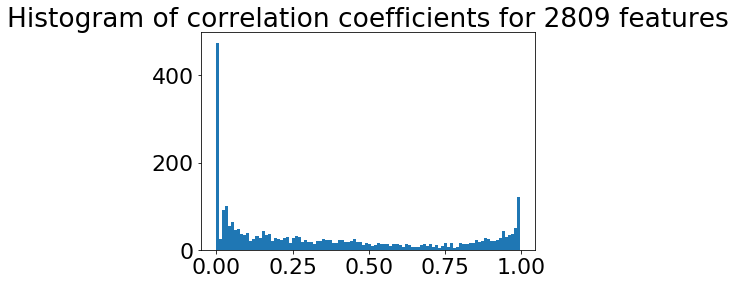

In [43]:
plt.hist(corr, bins=100)
plt.title('Histogram of correlation coefficients for 2809 features')
plt.show()

In [44]:
corr_filter = corr > 0.5

In [45]:
variance = np.var(data.iloc[:, 0:INPUT_DIM])

In [46]:
var_filter = variance != 0

In [47]:
feature_filter = corr_filter & var_filter

In [48]:
X_train_filtered = X_train_norm[:, feature_filter]
X_train_filtered.shape

(13802, 893)

In [49]:
X_train_filtered_wo_valid = X_train.iloc[:round(0.75*len(X_train)), :]
X_train_filtered_wo_valid = np.array(X_train_filtered_wo_valid)[:, feature_filter]

In [50]:
corr_names = []
for i in tnrange(2809):
    v, r = divmod(i, 7)
    corr_names.append([feature_names[v],
                      var_legend[r]['name'],
                      corr[i]])

In [51]:
corr_names_pd = pd.DataFrame(corr_names, columns=['name', 'group',
                                                  'corr_coeff'])

In [52]:
corr_groups = corr_names_pd.groupby('group')

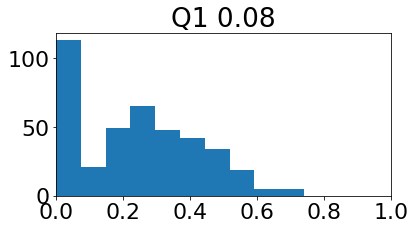

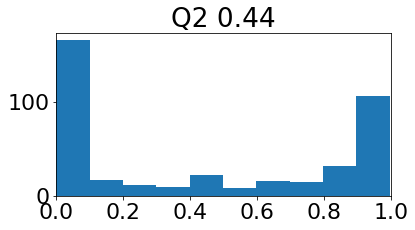

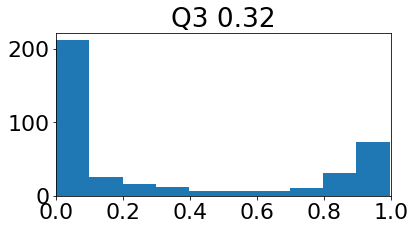

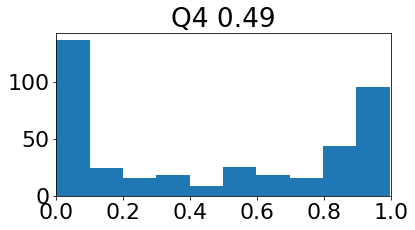

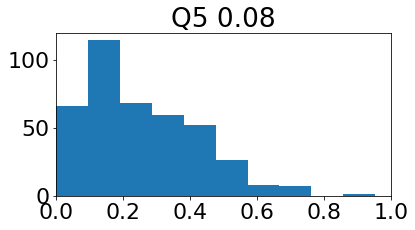

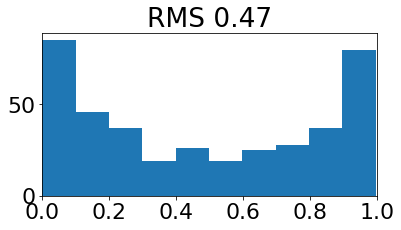

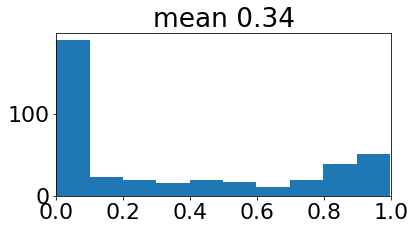

In [53]:
plt.rcParams['figure.figsize'] = [6, 3]
for n in corr_groups.groups.keys():
    coeffs = corr_groups.get_group(n).corr_coeff
    used = len(coeffs[coeffs > 0.5])/len(coeffs)
    plt.hist(corr_groups.get_group(n).corr_coeff, bins=10)
    plt.title(n + ' ' + str(round(used, 2)))
    plt.xlim([0, 1])
    plt.show()

In [54]:
corr_groups.aggregate(np.mean)

,corr_coeff
group,
Q1,0.237839
Q2,0.436154
Q3,0.328373
Q4,0.463632
Q5,0.251657
RMS,0.482351
mean,0.357707


In [55]:
corr_groups.aggregate(np.median)

,corr_coeff
group,
Q1,0.237408
Q2,0.377500
Q3,0.067840
Q4,0.486379
Q5,0.216388
RMS,0.450917
mean,0.157198


In [56]:
corr_groups.aggregate(np.std)

,corr_coeff
group,
Q1,0.187060
Q2,0.413011
Q3,0.396982
Q4,0.398927
Q5,0.168178
RMS,0.353454
mean,0.364646


In [57]:
csv_dir = '/afs/cern.ch/user/t/tkrzyzek/Documents/Data-Certification/visualization/'
corr_names_pd.to_csv(csv_dir + 'correlation_coeff_feature_names.csv', index=False)

In [61]:
input_dim = X_train_filtered.shape[1]
input_layer = Input(shape=(input_dim, ))

# x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(input_layer)
# x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(input_layer)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(32, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(16, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(32, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(64, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(128, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(256, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

x = Dense(512, kernel_regularizer=l1_l2(10e-5))(x)
x = PReLU()(x)

# x = Dense(1024, kernel_regularizer=l1_l2(10e-5))(x)
# x = PReLU()(x)

x = Dense(input_dim)(x)

autoencoder = Model(inputs=input_layer, outputs=x)

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 893)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 512)               457728    
_________________________________________________________________
p_re_lu_35 (PReLU)           (None, 512)               512       
_________________________________________________________________
dense_40 (Dense)             (None, 256)               131328    
_________________________________________________________________
p_re_lu_36 (PReLU)           (None, 256)               256       
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
p_re_lu_37 (PReLU)           (None, 128)               128       
__________

In [62]:
model_name2 = 'ae2'

In [63]:
adamm = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

early_stopper = EarlyStopping(monitor="val_loss",
                              patience=32,
                              verbose=True,
                              mode="auto")

autoencoder.compile(optimizer=adamm, loss='mean_squared_error')

checkpoint_callback = ModelCheckpoint(("%s%s.h5" % (model_directory, model_name2)),
                                      monitor="val_loss",
                                      verbose=False,
                                      save_best_only=True,
                                      mode="min")

In [64]:
autoencoder.fit(X_train_filtered,
                X_train_filtered,
                epochs=2048,
                batch_size=256,
                validation_split=0.25,
                verbose=2,
                callbacks=[early_stopper, checkpoint_callback])

Train on 10351 samples, validate on 3451 samples
Epoch 1/2048
2s - loss: 22.6160 - val_loss: 21.1447
Epoch 2/2048
1s - loss: 19.7686 - val_loss: 18.2310
Epoch 3/2048
1s - loss: 17.3364 - val_loss: 16.0233
Epoch 4/2048
1s - loss: 15.2140 - val_loss: 14.0479
Epoch 5/2048
1s - loss: 13.2719 - val_loss: 12.3876
Epoch 6/2048
1s - loss: 11.7025 - val_loss: 10.9374
Epoch 7/2048
1s - loss: 10.3386 - val_loss: 9.6652
Epoch 8/2048
1s - loss: 9.1433 - val_loss: 8.5497
Epoch 9/2048
1s - loss: 8.0953 - val_loss: 7.5720
Epoch 10/2048
1s - loss: 7.1766 - val_loss: 6.7137
Epoch 11/2048
1s - loss: 6.3714 - val_loss: 5.9623
Epoch 12/2048
1s - loss: 5.6662 - val_loss: 5.3052
Epoch 13/2048
1s - loss: 5.0489 - val_loss: 4.7304
Epoch 14/2048
1s - loss: 4.5100 - val_loss: 4.2275
Epoch 15/2048
1s - loss: 4.0393 - val_loss: 3.7881
Epoch 16/2048
1s - loss: 3.6284 - val_loss: 3.4052
Epoch 17/2048
1s - loss: 3.2695 - val_loss: 3.0711
Epoch 18/2048
1s - loss: 2.9559 - val_loss: 2.7785
Epoch 19/2048
1s - loss: 2.68

In [65]:
# Reload saved model
autoencoder = load_model("%s%s.h5" % (model_directory, model_name2))

In [66]:
X_test_filtered = X_test_norm[:, feature_filter]

In [67]:
# Exclude validation set
X_train_wo_valid_filtered = X_train_wo_valid[:, feature_filter]

In [68]:
X_test_filtered.shape

(14621, 893)

In [69]:
# Run predictions
ae_pred_filtered = autoencoder.predict(X_test_filtered)
ae_pred_filtered_train = autoencoder.predict(X_train_wo_valid_filtered)

In [70]:
pickle.dump(ae_pred_filtered, open(model_directory + "ae_pred_filtered.p", "wb"))
pickle.dump(ae_pred_filtered_train, open(model_directory + "ae_pred_filtered_train.p", "wb"))

In [72]:
ae_pred_filtered = pickle.load(open(model_directory + "ae_pred_filtered.p", "rb"))
ae_pred_filtered_train = pickle.load(open(model_directory + "ae_pred_filtered_train.p", "rb"))

In [73]:
ae_error_filtered = get_error_df(X_test_filtered, ae_pred_filtered, mode="topn", n_highest=100)
ae_error_filtered_train = get_error_df(X_train_wo_valid_filtered, ae_pred_filtered_train, mode="topn", n_highest=100)

In [74]:
pickle.dump(ae_error_filtered, open(model_directory + "ae_error_filtered.p", "wb"))
pickle.dump(ae_error_filtered_train, open(model_directory + "ae_error_filtered_train.p", "wb"))

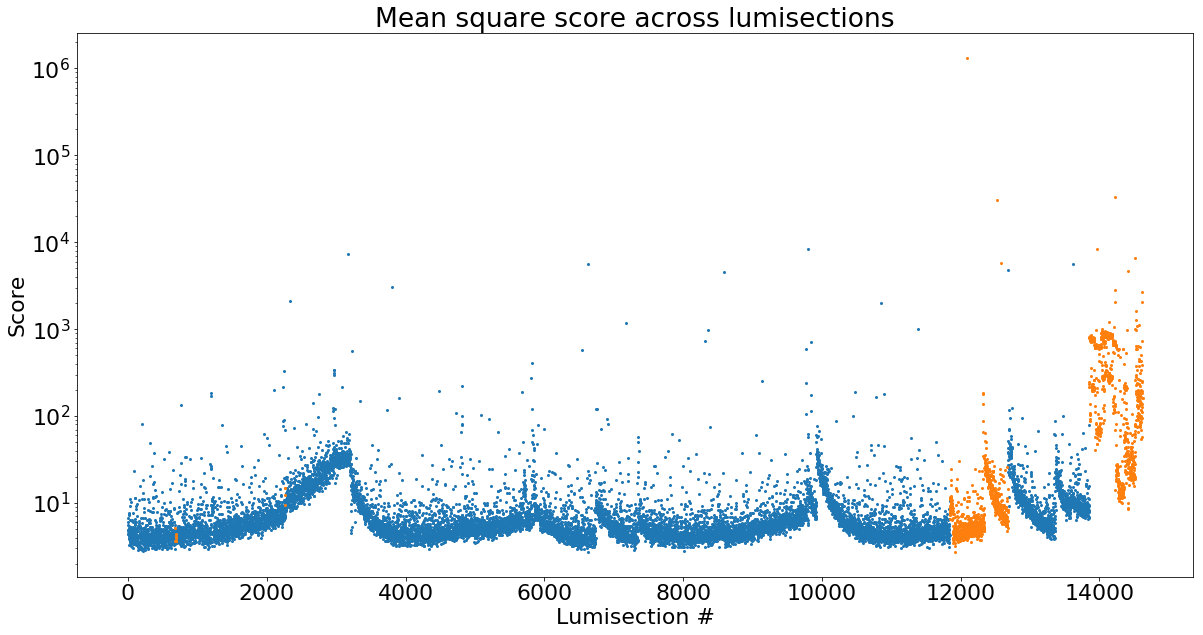

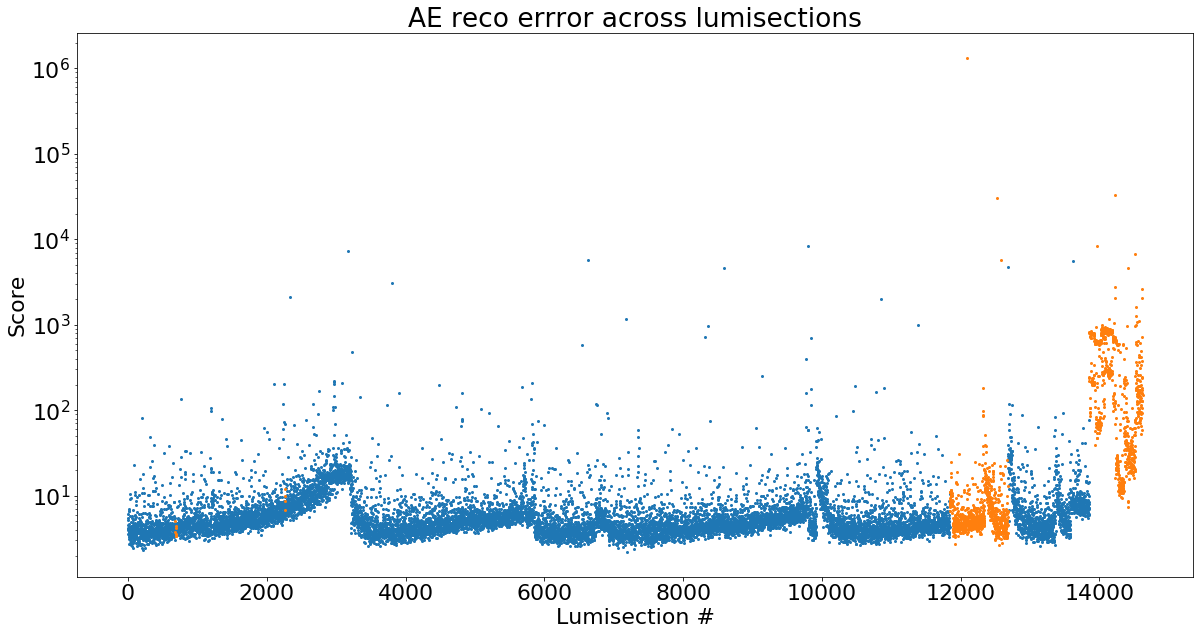

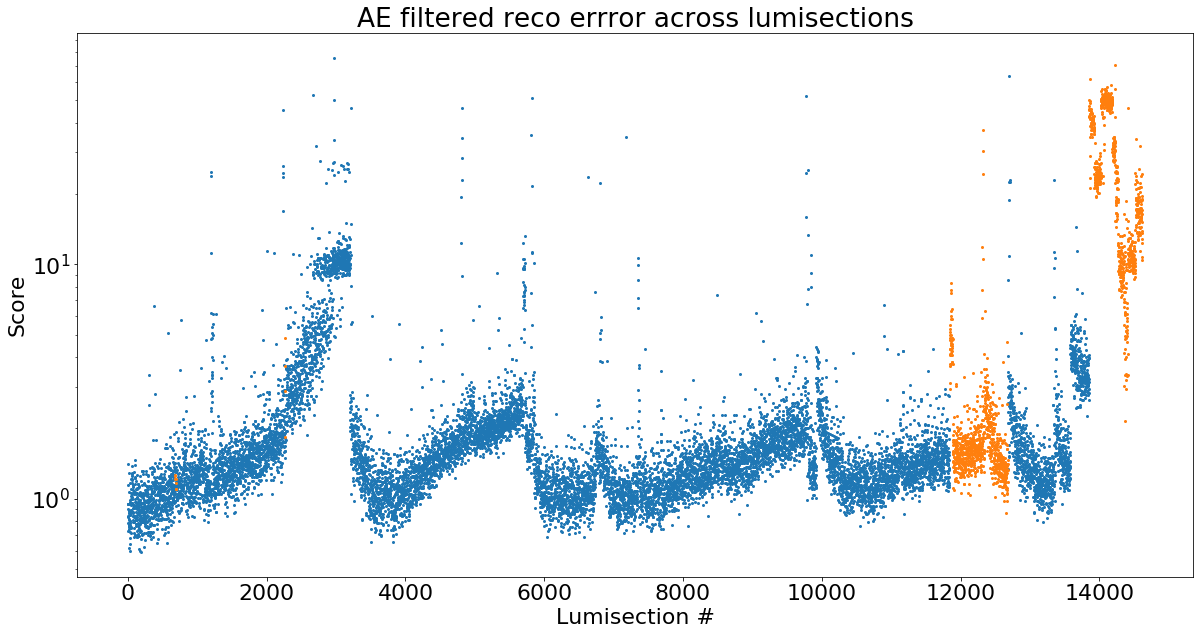

In [75]:
plt.rcParams['figure.figsize'] = [20, 10]
plot_lumi_error(np.zeros(ae_pred.shape), X_test_norm, title='Mean square score across lumisections')
plot_lumi_error(ae_pred, X_test_norm, title='AE reco errror across lumisections')
plot_lumi_error(ae_pred_filtered, X_test_filtered, 
                title='AE filtered reco errror across lumisections')

In [76]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve(label, pred, X_tests, names):
    """Generates ROC Curves for a given array"""
    scores = [get_error_df(X_tests[i], pred[i], mode='topn') for i in range(len(pred))]
    
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()

In [77]:
# Make ROC_curve

from sklearn.metrics import auc, roc_curve, roc_auc_score                          

def get_roc_curve_error(label, scores, names):
    """Generates ROC Curves for a given array"""    
    fig, ax = plt.subplots()
    
    for i in range(len(scores)):
        fpr, tpr, thresholds = roc_curve(label, scores[i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr,
                 tpr,
                 linewidth=3,
                 label=("%s AUC: %s" % (names[i], roc_auc)))
        
    plt.legend(frameon=False)
    plt.ylabel("Sensitivity (TPR)")
    plt.xlabel("Fall-out (TNR)")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.show()
    return plt

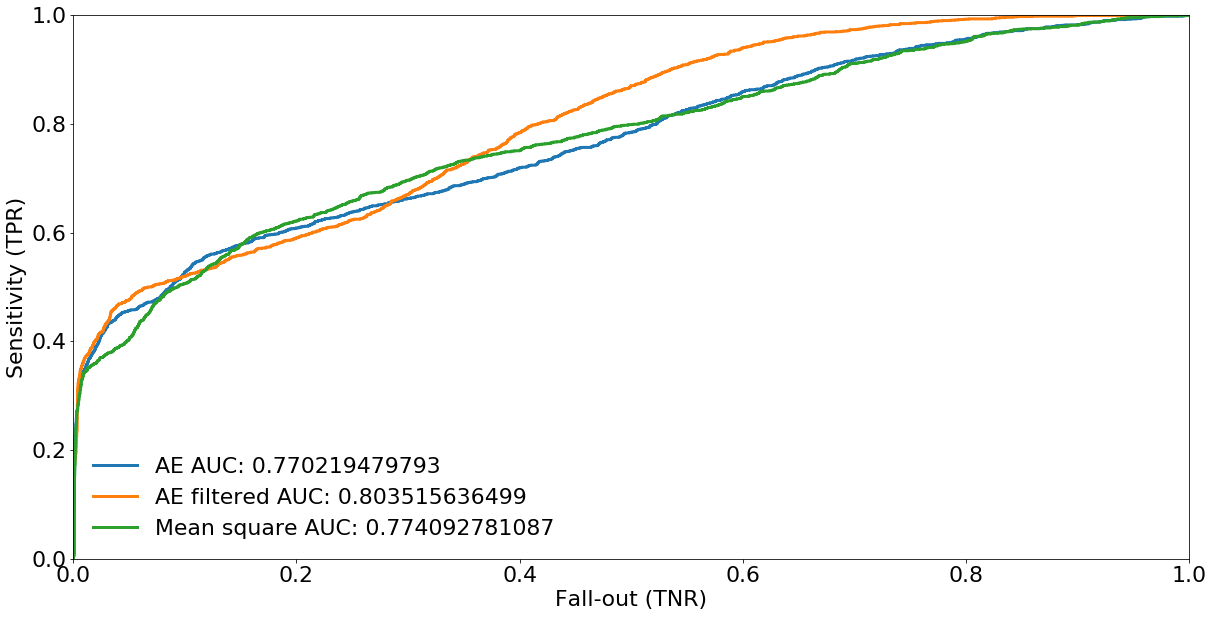

In [78]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test, 
                    [ae_error,
                     ae_error_filtered,
                     get_error_df(X_test_norm, np.zeros(X_test_norm.shape), mode="topn", n_highest=100)], 
                    ['AE',
                     'AE filtered',
                     'Mean square'])

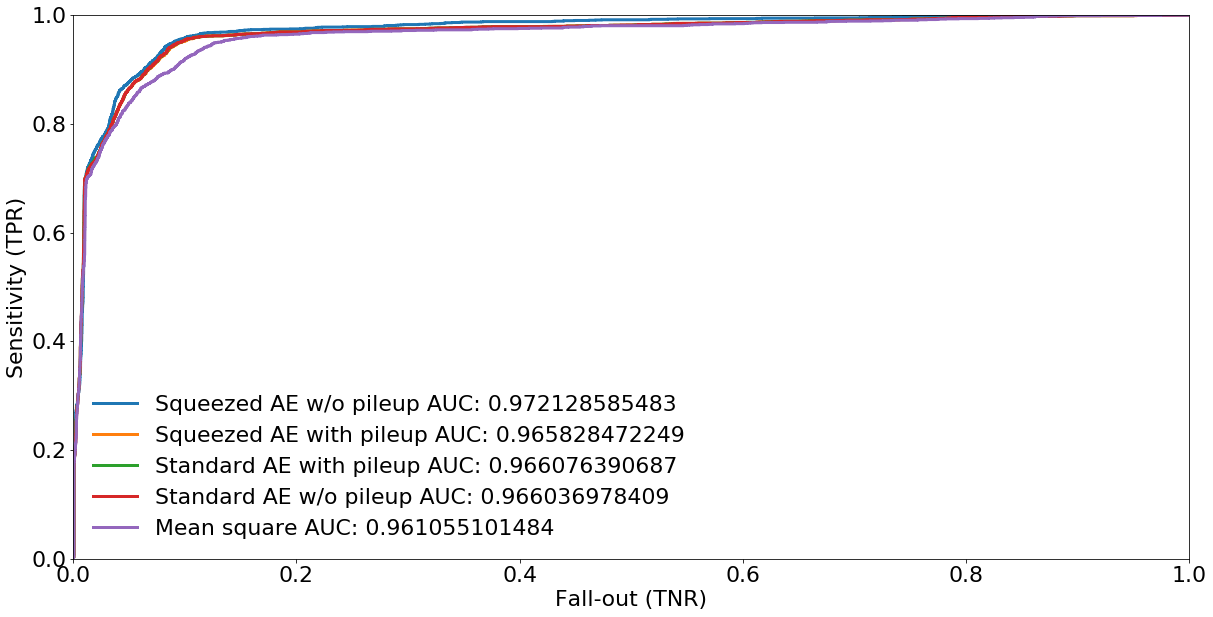

In [53]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test, 
                    [np_b_ae_error, p_b_ae_error, p_nb_ae_error, np_nb_ae_error, 
                     get_error_df(X_test_norm, np.zeros(X_test_norm.shape), mode="topn", n_highest=100)], 
                    ['Squeezed AE w/o pileup',
                     'Squeezed AE with pileup',
                     'Standard AE with pileup',
                     'Standard AE w/o pileup',
                     'Mean square'])

In [55]:
fig.savefig(csv_dir + 'roc_auc_filtered_ae.png')

NameError: name 'csv_dir' is not defined

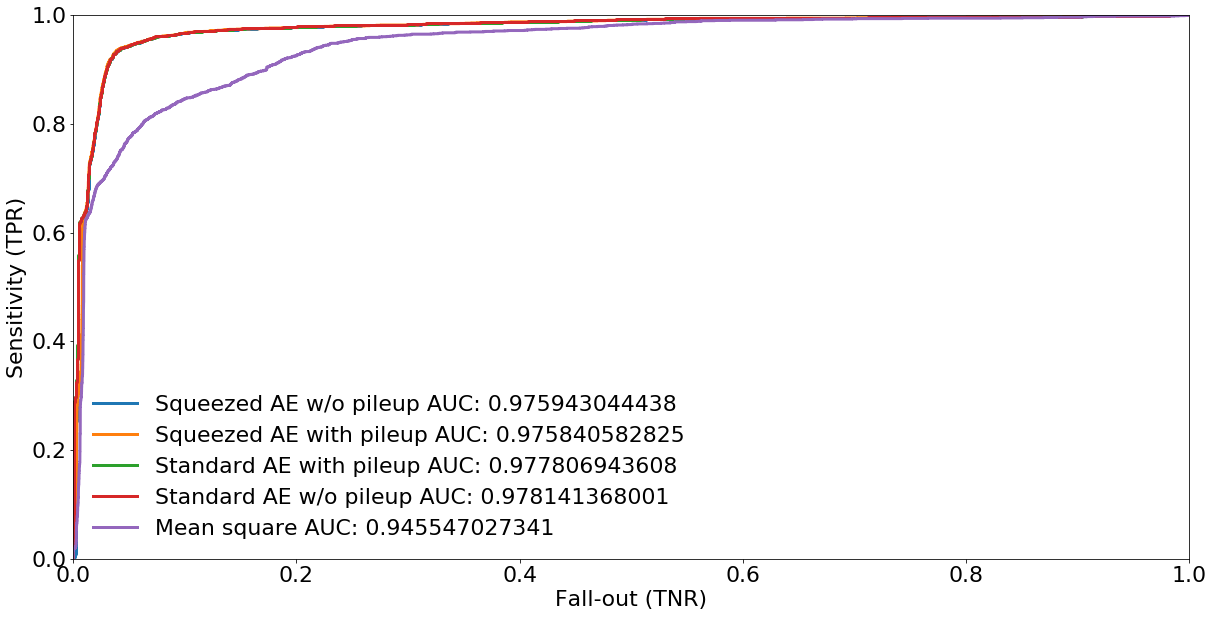

In [54]:
plt.rcParams['figure.figsize'] = [20, 10]
fig = get_roc_curve_error(y_test, 
                    [np_b_ae_error_filtered, p_b_ae_error_filtered, p_nb_ae_error_filtered,
                  np_nb_ae_error_filtered,
                     get_error_df(X_test_filtered, np.zeros(X_test_filtered.shape), mode="topn", n_highest=100)], 
                    ['Squeezed AE w/o pileup',
                     'Squeezed AE with pileup',
                     'Standard AE with pileup',
                     'Standard AE w/o pileup',
                     'Mean square'])

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

LABELS = ["Normal", "Anomalous"]

def conf_matrix(scores, y_true, threshold, title):
    y_pred = [1 if e > threshold else 0 for e in scores]
    conf_matrix = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.title(title)
    plt.show()

    acc = accuracy_score(y_true, y_pred)
    class_imbal = np.mean(1 - y_true)
    adj_acc = (acc - class_imbal) / (1 - class_imbal)

    print("Threshold:", threshold)
    print("Adjusted accuracy:", adj_acc)
    return threshold

In [ ]:
conf_matrix(ae_error_filtered, y_test, 1.5e0, '')

In [ ]:
def pred_vs_feature(y_val, x_val, y_class, y_name="", x_name="", selected=[], linear=False,
                    limit=False):
    '''
    Plots two arbitrary values agains each other.
    '''
    df = pd.DataFrame({'y_val': y_val,
                       'x_val': x_val,
                       'y_class': y_class})

    groups = df.groupby('y_class')
    fig, ax = plt.subplots()

    for name, group in groups:
        ax.plot(group.x_val, 
                group.y_val,
                color="red" if name == 1 else "blue",
                marker='o',
                ms=2,
                linestyle='',
                label= "Anomaly" if name == 1 else "Normal")

    for i in selected:
        ax.plot(x_val[i],
                y_val[i],
                color="green",
                marker='o',
                ms=4,
                linestyle='')
                 
    ax.legend()
    if not linear:
        ax.set_yscale('log')
    if limit:
        plt.xlim([limit[0], limit[1]])
    plt.grid()
    plt.ylabel(y_name)
    plt.xlabel(x_name)
    plt.show()

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error, X_test[2807], y_test, "AE reco error", "Luminosity")

In [ ]:
plt.rcParams['figure.figsize'] = [20, 10]
pred_vs_feature(ae_error_filtered, X_test[2807], y_test, "AE reco error", "Luminosity")

In [44]:
model_directory_np_b = "/eos/user/t/tkrzyzek/autoencoder/plots_train_bottleneck/"
model_directory_p_b = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup/"
model_directory_p_nb = "/eos/user/t/tkrzyzek/autoencoder/plots_train_w_pileup_no_bottleneck/"
model_directory_np_nb = "/eos/user/t/tkrzyzek/autoencoder/plots_train_no_pileup_no_bottleneck/"

In [45]:
np_b_ae_error = pickle.load(open(model_directory_np_b + "ae_error.p", "rb"))
np_b_ae_error_filtered = pickle.load(open(model_directory_np_b + "ae_error_filtered.p", "rb"))

p_b_ae_error = pickle.load(open(model_directory_p_b + "ae_error.p", "rb"))
p_b_ae_error_filtered = pickle.load(open(model_directory_p_b + "ae_error_filtered.p", "rb"))


p_nb_ae_error = pickle.load(open(model_directory_p_nb + "ae_error.p", "rb"))
p_nb_ae_error_filtered = pickle.load(open(model_directory_p_nb + "ae_error_filtered.p", "rb"))


np_nb_ae_error = pickle.load(open(model_directory_np_nb + "ae_error.p", "rb"))
np_nb_ae_error_filtered = pickle.load(open(model_directory_np_nb + "ae_error_filtered.p", "rb"))

In [ ]:
def pred_vs_feature4(y_vals, x_val, y_class, titles, y_name="", x_name="", linear=False, 
                     limit=False, name_plt=''):
    '''
    Plots two arbitrary values agains each other.
    '''
    fig, axes = plt.subplots(2, 2)
    
    for i in range(4):
        df = pd.DataFrame({'y_val': y_vals[i],
                           'x_val': x_val,
                           'y_class': y_class})

        groups = df.groupby('y_class')
        if i < 2:
            ax = axes[0, i%2]
        else:
            ax = axes[1, i%2]
        
        for name, group in groups:
            ax.plot(group.x_val, 
                    group.y_val,
                    color="red" if name == 1 else "blue",
                    marker='o',
                    ms=2,
                    linestyle='',
                    label= "Anomaly" if name == 1 else "Normal")

        ax.legend()
        if not linear:
            ax.set_yscale('log')
        if limit:
            plt.xlim([limit[0], limit[1]])
        ax.set_ylabel(y_name)
        ax.set_xlabel(x_name)
        ax.set_title(titles[i])
        plt.grid()
    plt.show()
    plt.savefig(csv_dir + name_plt)

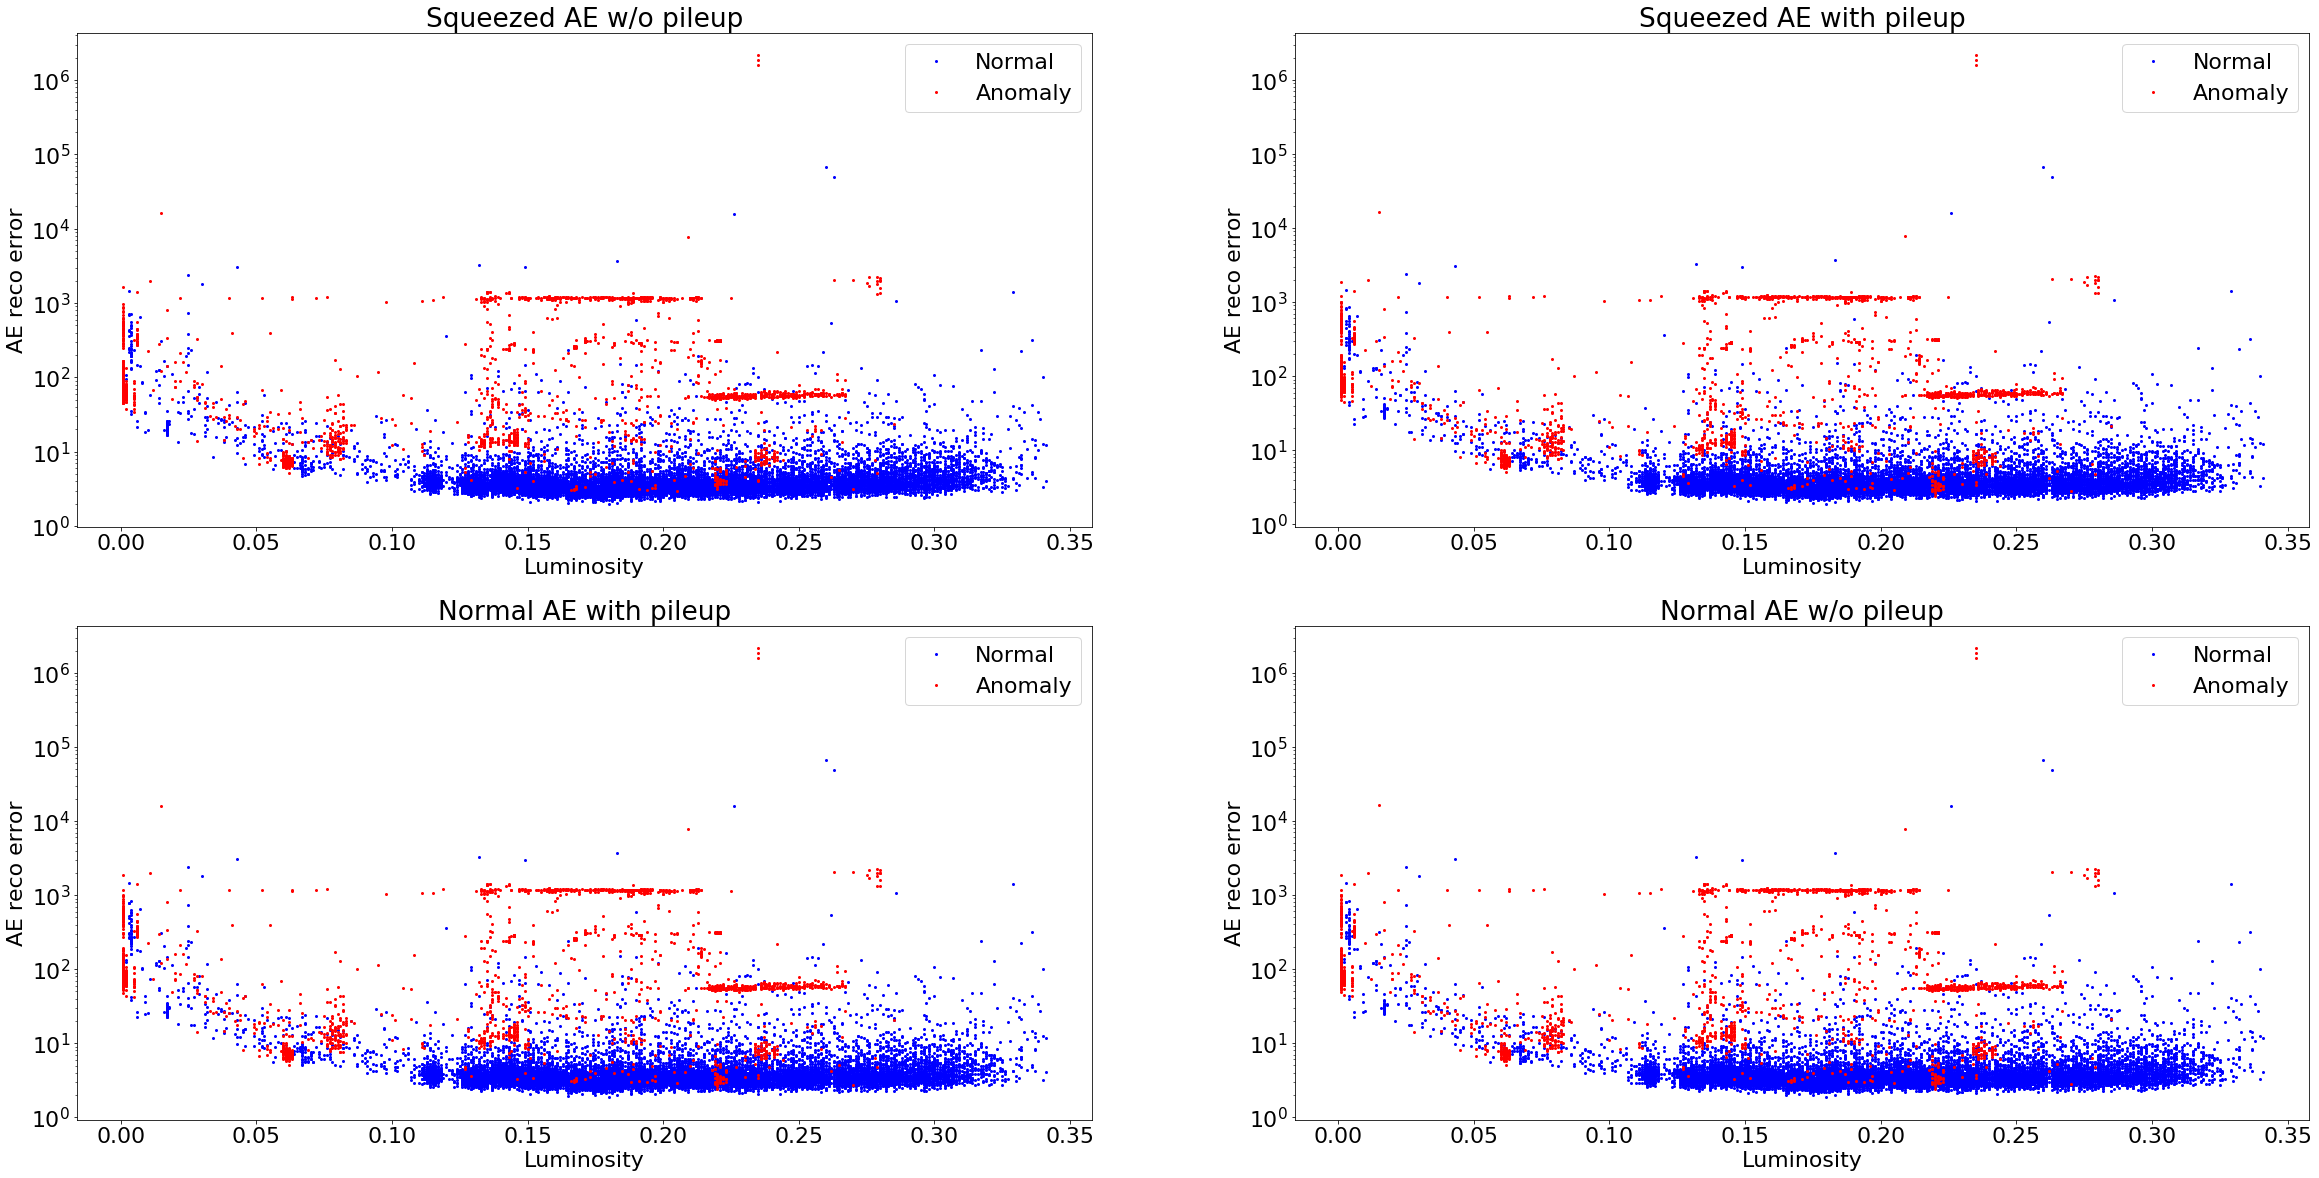

In [148]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error, p_b_ae_error, p_nb_ae_error, np_nb_ae_error],
                X_test[2807], y_test, ['Squeezed AE w/o pileup', 'Squeezed AE with pileup',
                                      'Normal AE with pileup', 'Normal AE w/o pileup'],
                 "AE reco error", "Luminosity", name_plt='ae_vs_luminosity.png')

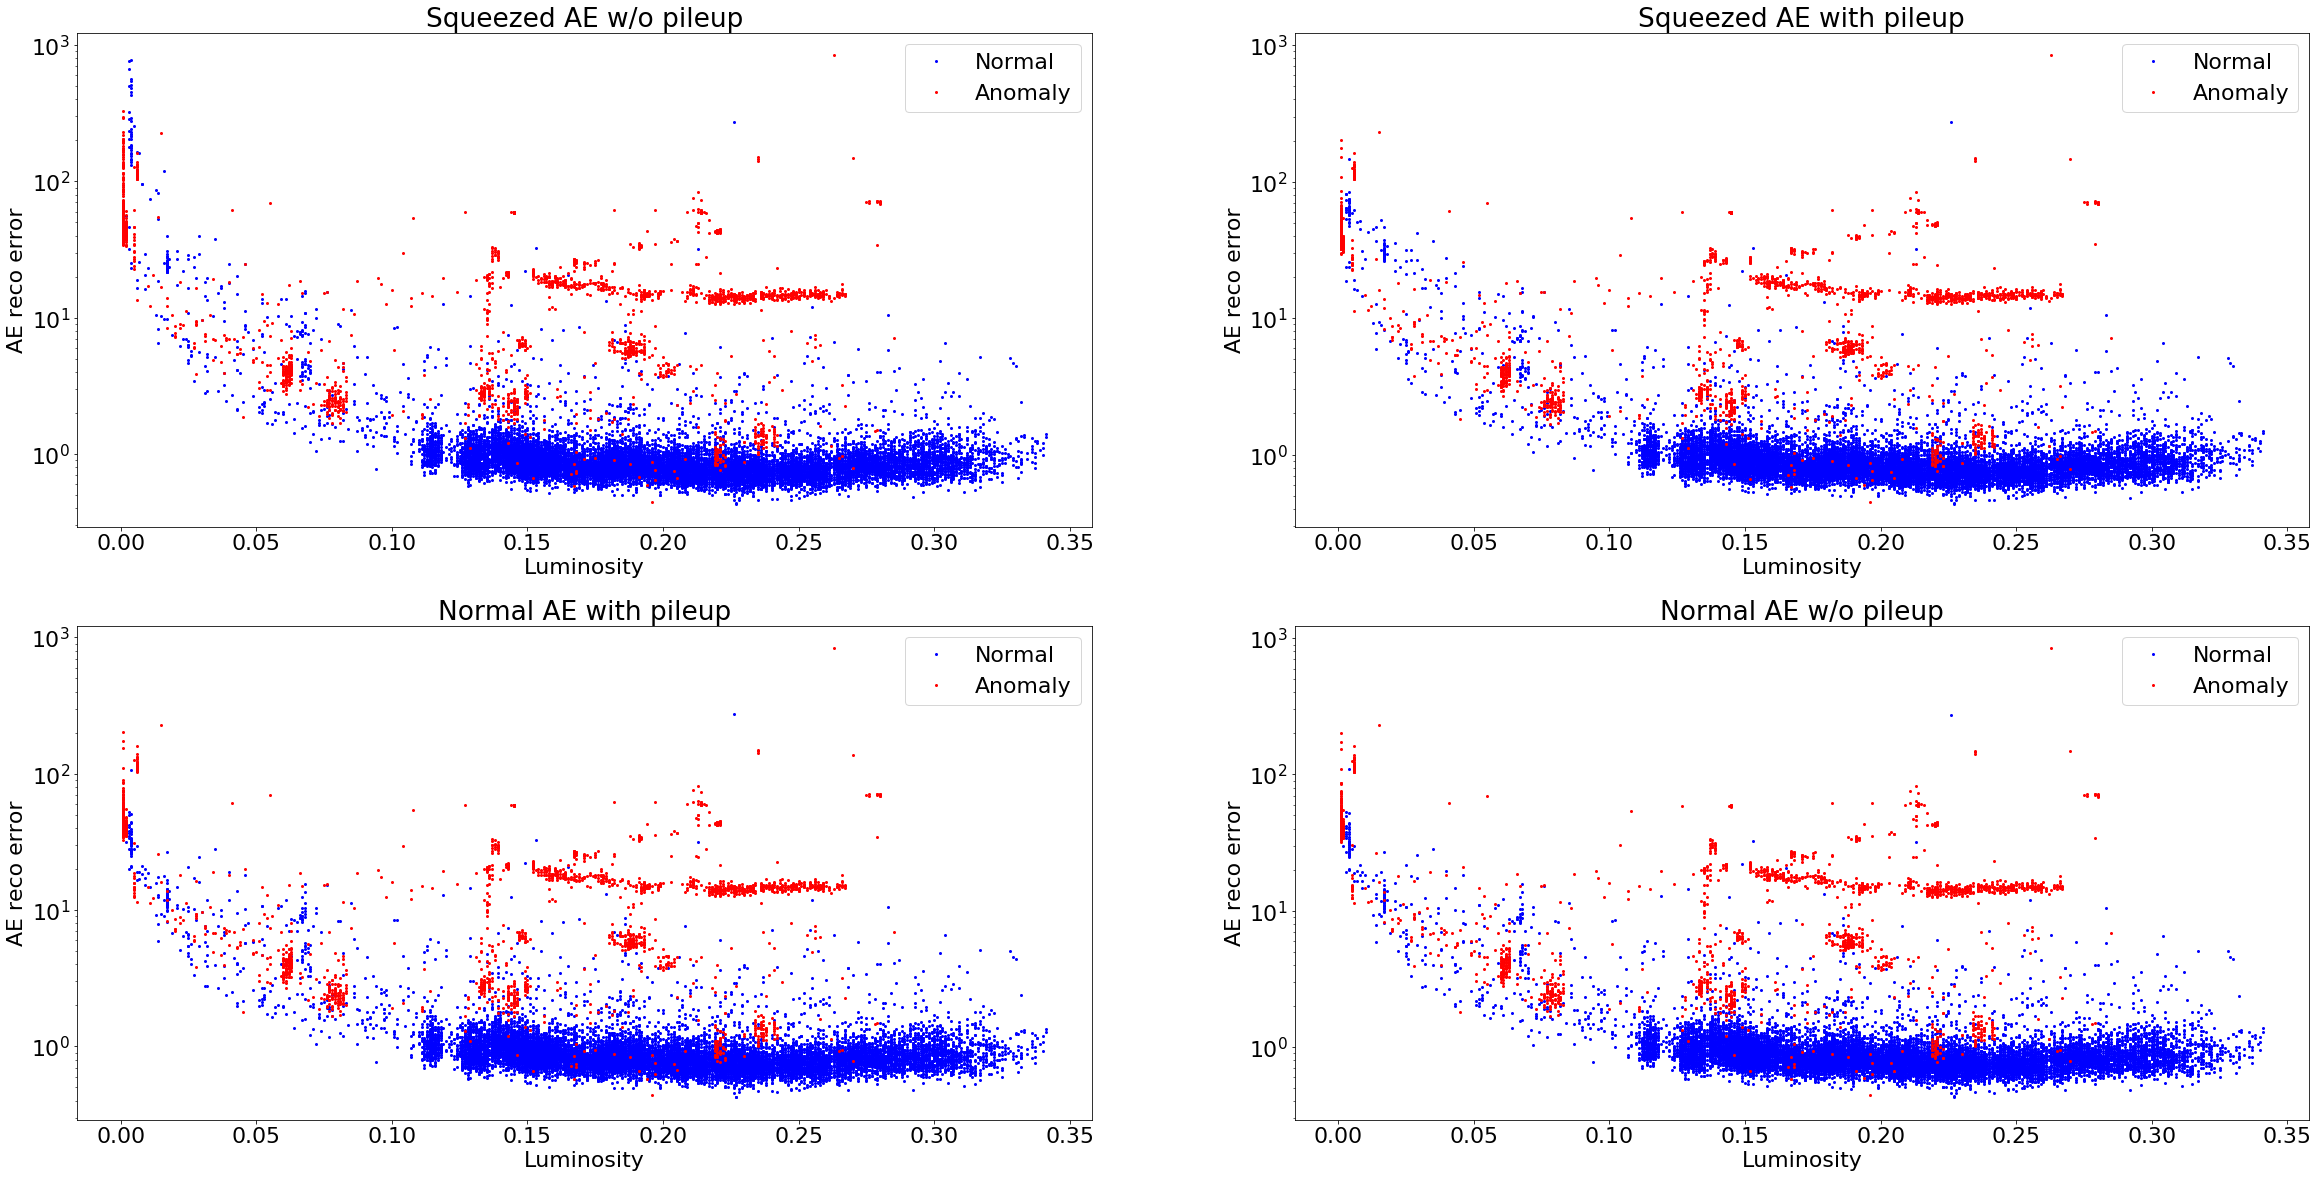

In [149]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error_filtered, p_b_ae_error_filtered, p_nb_ae_error_filtered,
                  np_nb_ae_error_filtered], X_test[2807], y_test,
                 ['Squeezed AE w/o pileup', 'Squeezed AE with pileup',
                 'Normal AE with pileup', 'Normal AE w/o pileup'],
                 "AE reco error", "Luminosity", name_plt='filtered_ae_vs_luminosity.png')

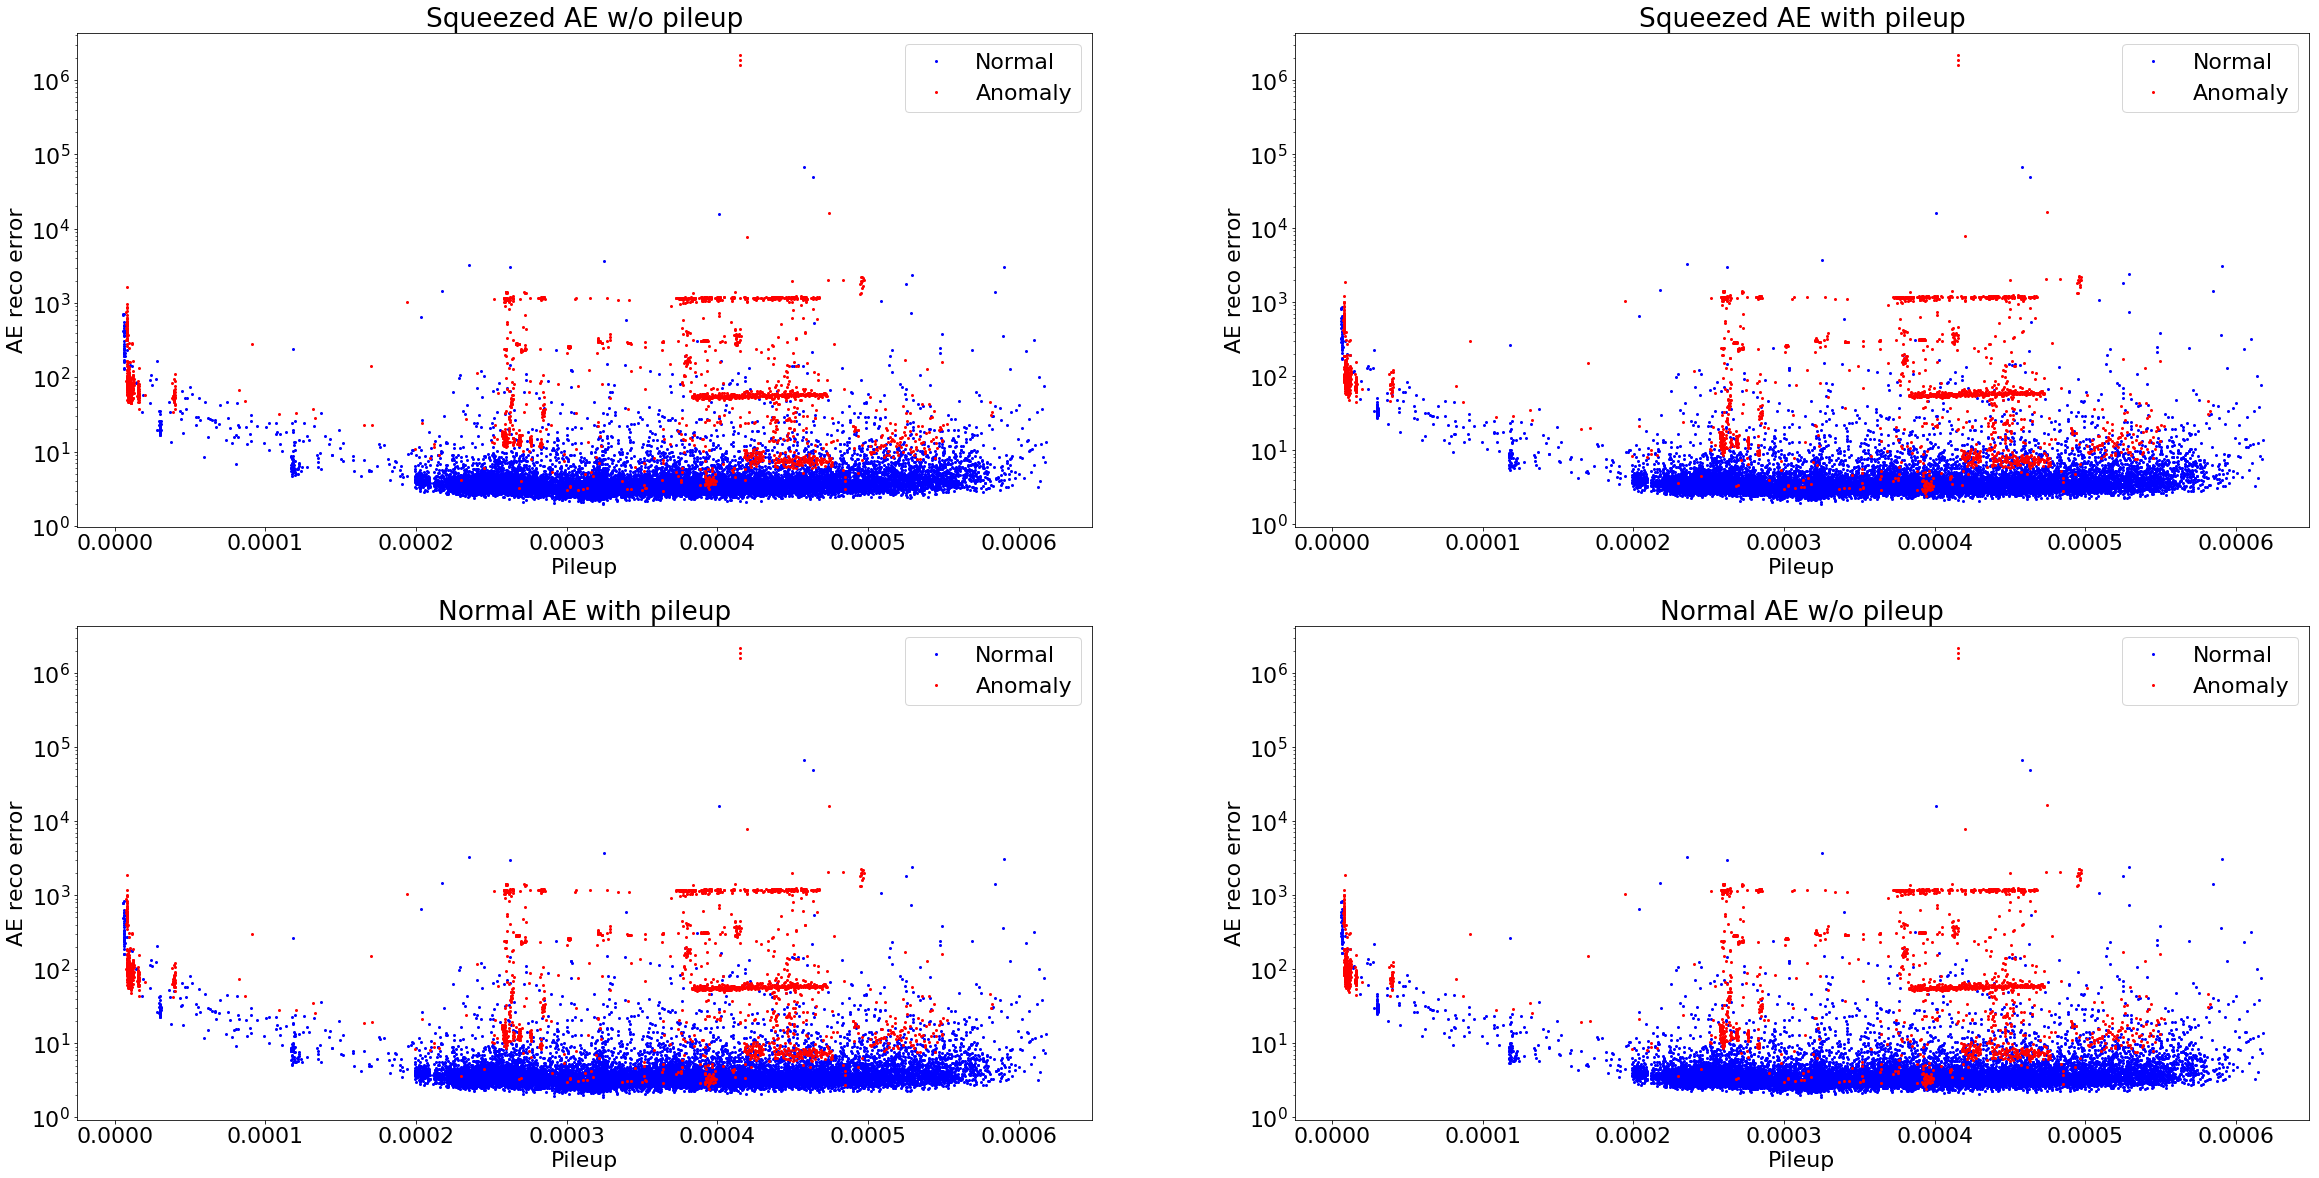

In [150]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error, p_b_ae_error, p_nb_ae_error, np_nb_ae_error],
                X_test[2808], y_test, ['Squeezed AE w/o pileup', 'Squeezed AE with pileup',
                                      'Normal AE with pileup', 'Normal AE w/o pileup'],
                 "AE reco error", "Pileup", name_plt='ae_vs_pileup.png')

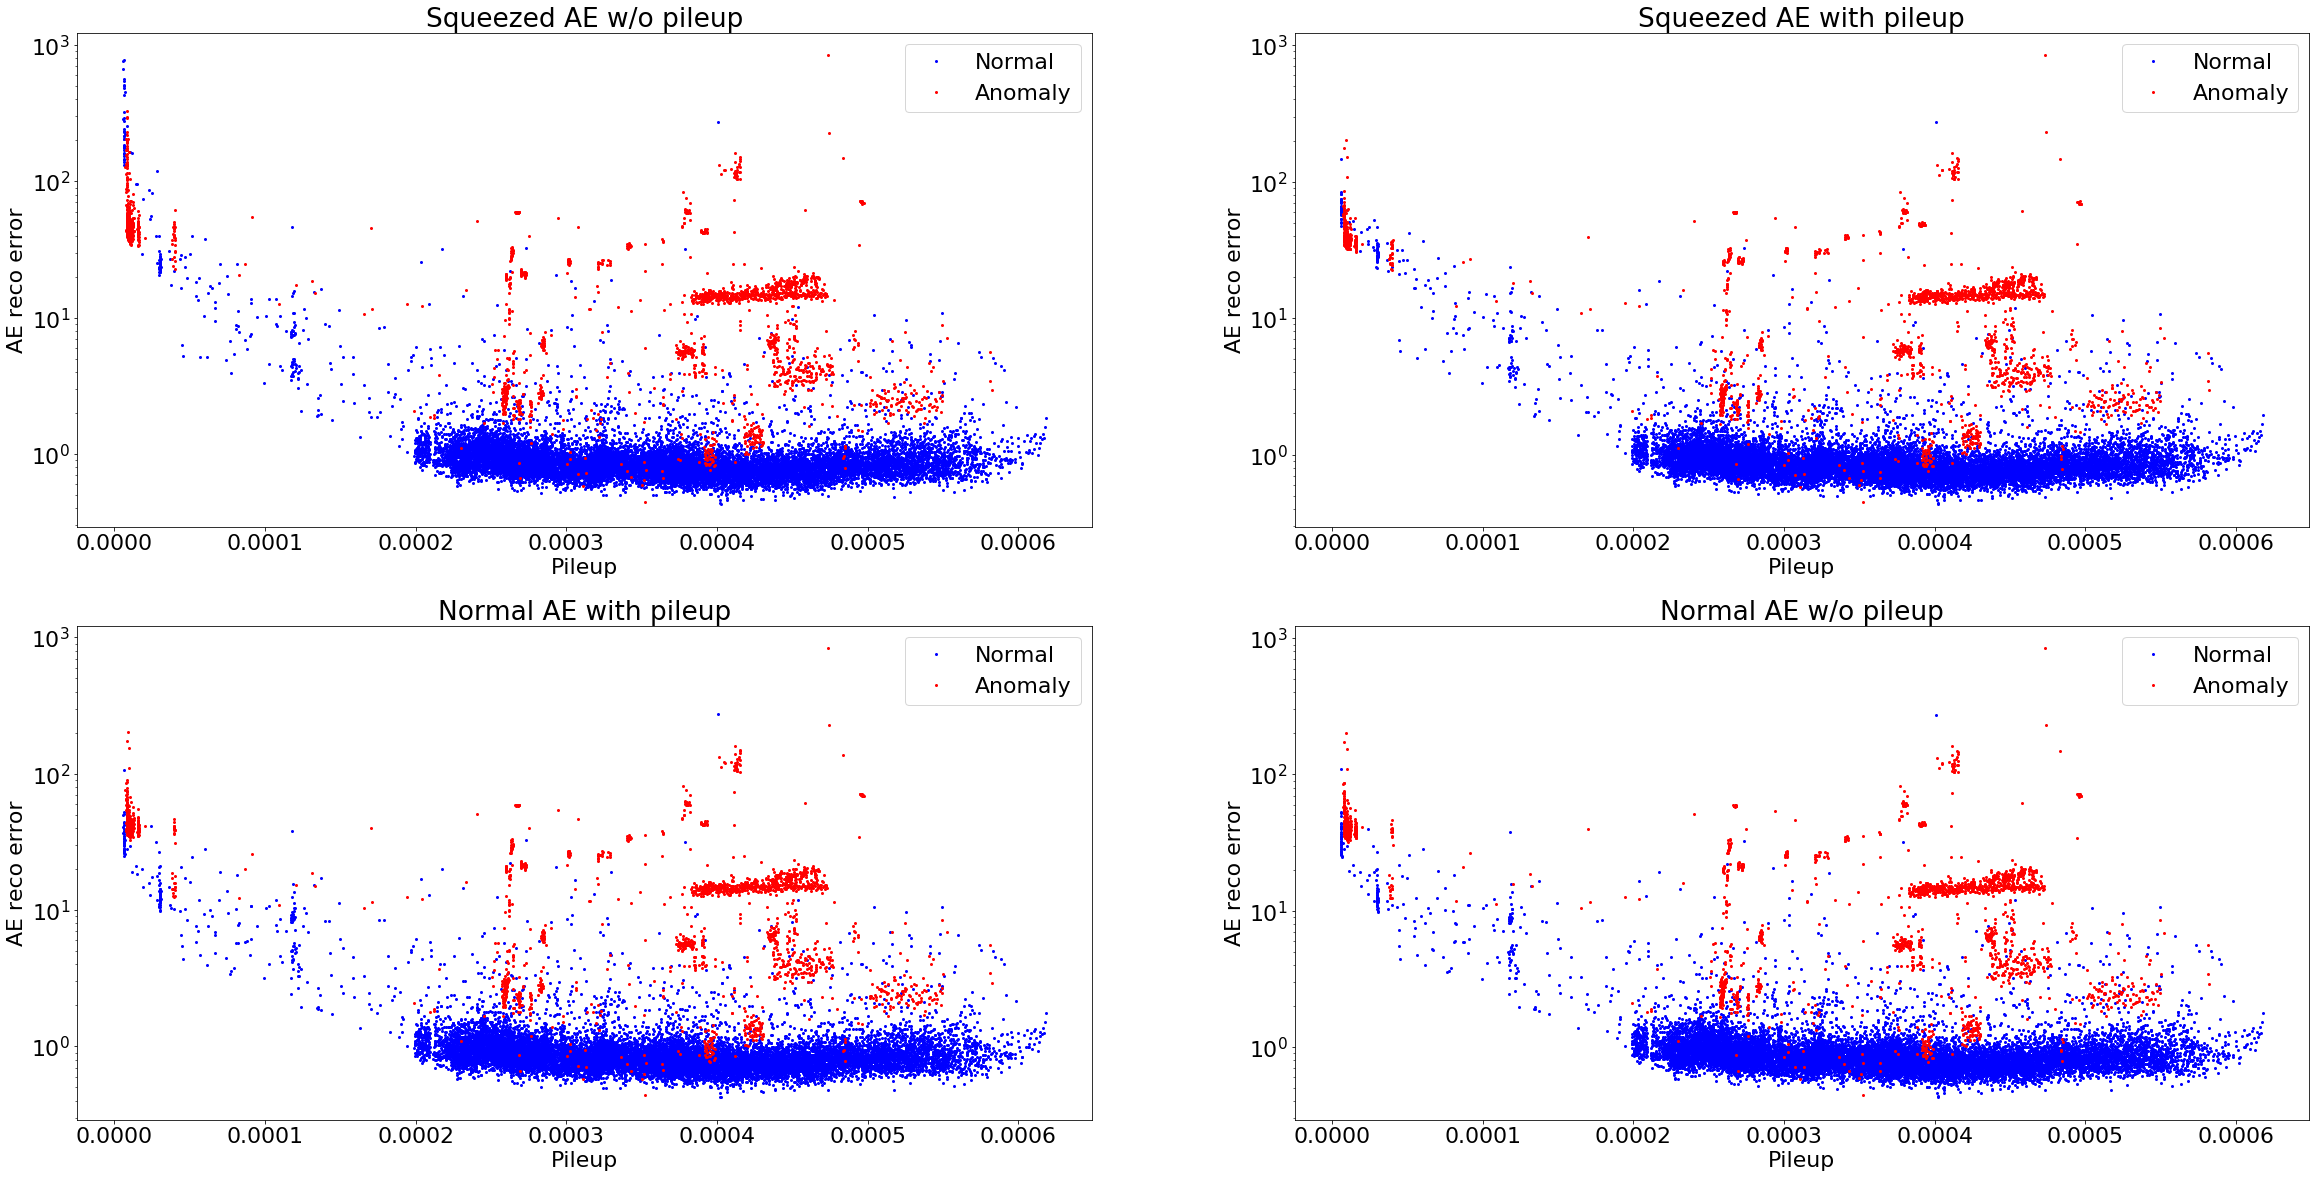

In [151]:
plt.rcParams['figure.figsize'] = [40, 20]
pred_vs_feature4([np_b_ae_error_filtered, p_b_ae_error_filtered, p_nb_ae_error_filtered,
                  np_nb_ae_error_filtered], X_test[2808], y_test, 
                 ['Squeezed AE w/o pileup', 'Squeezed AE with pileup',
                                      'Normal AE with pileup', 'Normal AE w/o pileup'],
                 "AE reco error", "Pileup", name_plt='filtered_ae_vs_pileup.png')